In [15]:
import os
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.mixture import BayesianGaussianMixture
from scipy.spatial.distance import mahalanobis
from sklearn.metrics import silhouette_score

# 设定数据路径
train_file_path = r'newwgz.csv'  # 训练文件路径
test_file_path = r'newgz.csv'  # 测试文件路径
output_result_path = r'total_result1.csv'  # 输出结果文件路径

columns_to_use = [
    "Time",
    "chaos",
    "system_usage",               # 系统使用率
    "user_usage",                 # 用户使用率
    "total_cpu_usage",
    "load_1min",                  # 1分钟负载
    "load_5min",                  # 5分钟负载
    "load_15min",                 # 15分钟负载
    "CurrEstab",
    "TCP_tw",
    "Tcp_InSegs",
    "Tcp_OutSegs",
    "Tcp_RetransSegs",
    "total_memory",              # 总内存
    "memory_used",               # 已用
    "memory_free",               # 可用
    "total-cache-buf-free",      # 192.168.49.2:9100_已用(total-cache-buf-free)
    "vda_io_util_percent",       # vda_每秒I/O操作%
]

columns_to_use = [col for col in columns_to_use if col != "Time"]
columns_to_use = [col for col in columns_to_use if col != "chaos"]
try:
    # 1. 训练阶段 - 使用data1.csv
    print("正在训练模型...")
    # 预读取并清洗列名
    raw_df = pd.read_csv(train_file_path, usecols=columns_to_use, encoding='gbk')

    raw_df.columns = raw_df.columns.str.strip()  # 去掉空格
    columns_available = raw_df.columns

    # 找出缺失的列
    missing_columns = set(columns_to_use) - set(columns_available)
    if missing_columns:
        print("以下列在 CSV 文件中未找到：", missing_columns)
        raise ValueError("列名不匹配，检查是否拼写错误或存在空格/编码问题")

    # 只选用需要的列
    train_df = raw_df[columns_to_use]

    # train_df = pd.read_csv(train_file_path, usecols=columns_to_use)
    
    # 使用SimpleImputer填充缺失值
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_train = imputer.fit_transform(train_df[columns_to_use])
    
    # 通过轮廓系数确定最佳聚类数
    print("正在通过轮廓系数确定最佳聚类数...")
    best_n = 2  # 至少2个聚类
    best_score = -1
    max_n = 10  # 尝试的最大聚类数
    
    for n in range(2, max_n + 1):
        bgmm = BayesianGaussianMixture(n_components=n, random_state=0)
        labels = bgmm.fit_predict(X_train)
        score = silhouette_score(X_train, labels)
        print(f"聚类数 n={n} 的轮廓系数: {score:.4f}")
        if score > best_score:
            best_score = score
            best_n = n
    
    n_components = best_n
    print(f"最优聚类数确定为: {n_components} (轮廓系数={best_score:.4f})")
    
    # 使用最佳聚类数训练最终模型
    bgmm = BayesianGaussianMixture(n_components=n_components, random_state=0)
    bgmm.fit(X_train)
    
    # 计算每个簇的逆协方差矩阵
    inv_covariances = [np.linalg.inv(cov) for cov in bgmm.covariances_]
    
    # 对每个簇计算马氏距离的最大值作为阈值
    mahalanobis_thresholds = []
    for i in range(n_components):
        component_data = X_train[bgmm.predict(X_train) == i]
        max_distance = np.max([
            mahalanobis(vector, bgmm.means_[i], inv_covariances[i])
            for vector in component_data
        ])
        mahalanobis_thresholds.append(max_distance)
    
    print(f"训练完成. 各簇的马氏距离阈值: {mahalanobis_thresholds}")
    
    # 2. 检测阶段 - 使用data2.csv
    print("正在检测异常点...")
    test_df = pd.read_csv(test_file_path)
    
    # 保存原始列（包括Time等所有列）
    result_df = test_df.copy()
    
    # 准备用于检测的数据（仅使用建模特征）
    X_test = imputer.transform(test_df[columns_to_use])
    
    # 为每行数据添加异常标记
    anomaly_flags = []
    for index, row in test_df.iterrows():
        vector = row[columns_to_use].values
        distances = []
        for i in range(n_components):
            mahalanobis_distance = mahalanobis(vector, bgmm.means_[i], inv_covariances[i])
            distances.append(mahalanobis_distance)
        
        min_distance = np.min(distances)
        cluster_index = np.argmin(distances)
        
        if min_distance > mahalanobis_thresholds[cluster_index] * mahalanobis_thresholds[cluster_index]:
            anomaly_flags.append(1)  # 异常
        else:
            anomaly_flags.append(0)  # 正常
    
    # 添加异常标记列
    result_df['chaos'] = anomaly_flags

    # 保存结果到CSV
    result_df.to_csv(output_result_path, index=False)
    print(f"检测完成. 结果已保存到 {output_result_path}")
    print(f"异常点总数: {sum(anomaly_flags)}")

    
except Exception as e:
    print(f"程序出错: {e}")


正在训练模型...
正在通过轮廓系数确定最佳聚类数...
聚类数 n=2 的轮廓系数: 0.5424


d:\appdownload\Anaconda\Anaconda3-2022.10\envs\new_env\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
d:\appdownload\Anaconda\Anaconda3-2022.10\envs\new_env\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


聚类数 n=3 的轮廓系数: 0.4395
聚类数 n=4 的轮廓系数: 0.1791
聚类数 n=5 的轮廓系数: 0.1422


d:\appdownload\Anaconda\Anaconda3-2022.10\envs\new_env\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
d:\appdownload\Anaconda\Anaconda3-2022.10\envs\new_env\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
d:\appdownload\Anaconda\Anaconda3-2022.10\envs\new_env\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


聚类数 n=6 的轮廓系数: 0.2126
聚类数 n=7 的轮廓系数: 0.0366


d:\appdownload\Anaconda\Anaconda3-2022.10\envs\new_env\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
d:\appdownload\Anaconda\Anaconda3-2022.10\envs\new_env\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


聚类数 n=8 的轮廓系数: 0.1777
聚类数 n=9 的轮廓系数: 0.0391


d:\appdownload\Anaconda\Anaconda3-2022.10\envs\new_env\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
d:\appdownload\Anaconda\Anaconda3-2022.10\envs\new_env\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


聚类数 n=10 的轮廓系数: 0.0410
最优聚类数确定为: 2 (轮廓系数=0.5424)
训练完成. 各簇的马氏距离阈值: [28.197109122461967, 11.679797230689793]
正在检测异常点...


d:\appdownload\Anaconda\Anaconda3-2022.10\envs\new_env\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


检测完成. 结果已保存到 total_result1.csv
异常点总数: 349


In [23]:
import csv

def calculate_overlap(text1, text2):
    # 把字符串按空格拆分成单词集合（可根据需要改为按字符或其它分隔）
    set1 = set(text1.strip().split())
    set2 = set(text2.strip().split())
    
    if not set1 and not set2:
        return 1.0  # 都是空的
    if not set1 or not set2:
        return 0.0  # 一个为空
    return len(set1 & set2) / len(set1 | set2)

def compare_csv_third_column(file1, file2):
    with open(file1, 'r', encoding='utf-8') as f1, open(file2, 'r', encoding='utf-8') as f2:
        reader1 = csv.reader(f1)
        reader2 = csv.reader(f2)

        total_overlap = 0
        row_count = 0

        for row1, row2 in zip(reader1, reader2):
            if len(row1) < 3 or len(row2) < 3:
                continue  # 如果某一行缺第三列就跳过
            col1 = row1[1]
            col2 = row2[1]

            overlap = calculate_overlap(col1, col2)
            total_overlap += overlap
            row_count += 1
            # print(f"第{row_count}行第三列重合度: {overlap:.2%}")

        average_overlap = total_overlap / row_count if row_count else 0
        print(f"\n总体平均重合度: {average_overlap:.2%}")

# 调用函数
compare_csv_third_column('newgz.csv', 'total_result.csv')



总体平均重合度: 87.20%


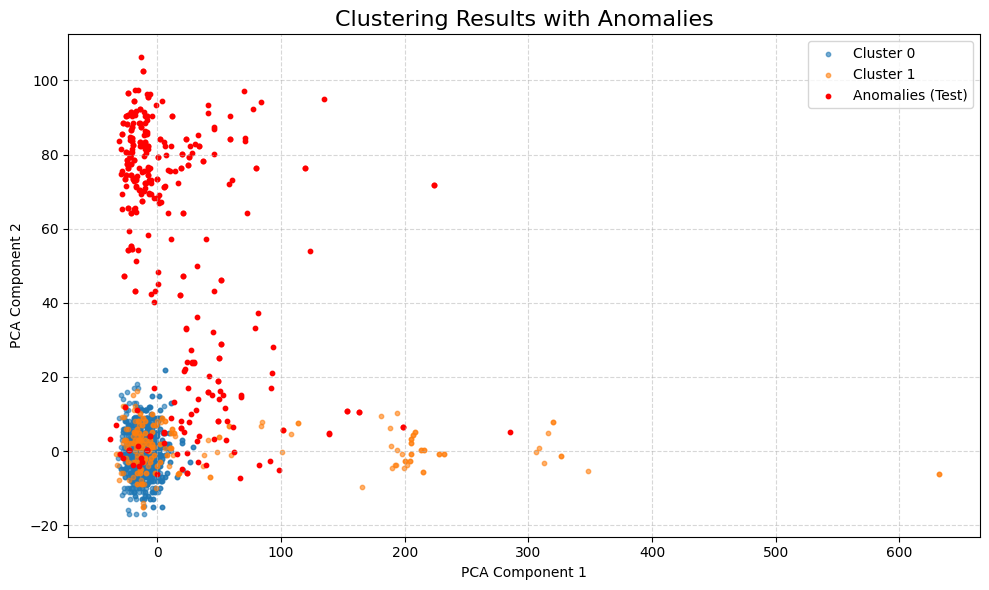

In [ ]:
# 没画正常点

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 将训练集降维为2D
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
train_labels = bgmm.predict(X_train)

# 将测试集也降维
X_test_2d = pca.transform(X_test)

# 绘图开始
plt.figure(figsize=(10, 6))

# 绘制训练集聚类点（不同颜色）
for cluster_id in np.unique(train_labels):
    cluster_points = X_train_2d[train_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}", s=10,alpha=0.6)

# 绘制测试集中的异常点
anomaly_indices = [i for i, val in enumerate(anomaly_flags) if val == 1]
if anomaly_indices:
    plt.scatter(X_test_2d[anomaly_indices, 0], X_test_2d[anomaly_indices, 1],
                color='red', marker='o', label='Anomalies (Test)', s=10)

plt.title("Clustering Results with Anomalies", fontsize=16)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


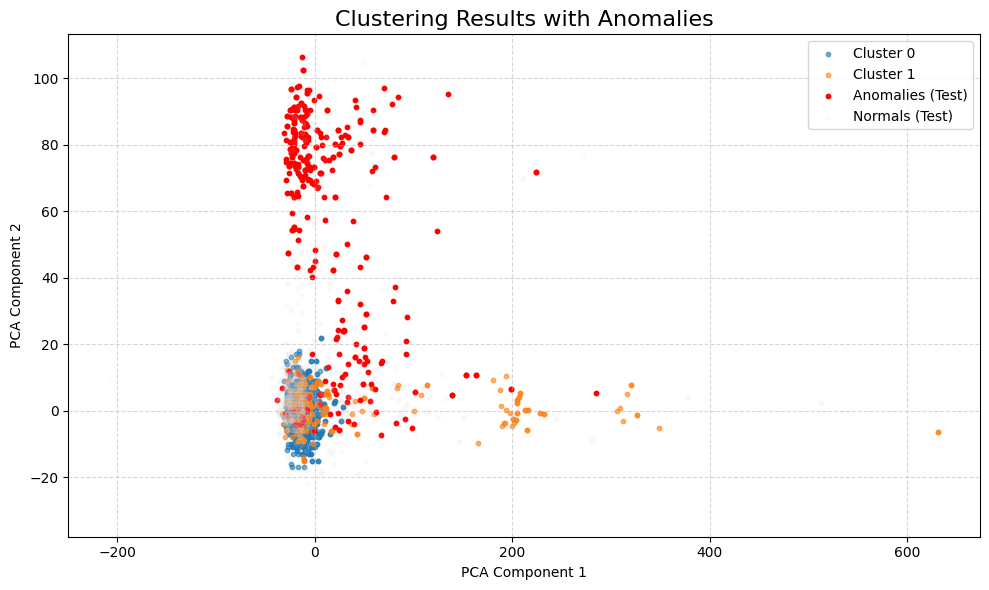

In [ ]:
# 画出正常点

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# 将训练集降维为2D
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
train_labels = bgmm.predict(X_train)

# 将测试集也降维
X_test_2d = pca.transform(X_test)

# 绘图开始
plt.figure(figsize=(10, 6))

# 绘制训练集聚类点（不同颜色）
for cluster_id in np.unique(train_labels):
    cluster_points = X_train_2d[train_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}", s=10, alpha=0.6)

# 绘制测试集中的异常点
anomaly_indices = [i for i, val in enumerate(anomaly_flags) if val == 1]
if anomaly_indices:
    plt.scatter(X_test_2d[anomaly_indices, 0], X_test_2d[anomaly_indices, 1],
                color='red', marker='o', label='Anomalies (Test)', s=10)

# 绘制测试集中的正常点
normal_indices = [i for i, val in enumerate(anomaly_flags) if val == 0]  # 假设正常点的标记为0
if normal_indices:
    plt.scatter(X_test_2d[normal_indices, 0], X_test_2d[normal_indices, 1],
                color='lightgray', marker='o', label='Normals (Test)', s=10, alpha=0.05)

# 添加标题和标签
plt.title("Clustering Results with Anomalies", fontsize=16)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()